In [1]:
import numpy as np
import matplotlib.pyplot as plt
import brainpy.math as bm
from Network_Multiple_Maps import Place_net

In [2]:
z_min = 0
z_max = 20
place_num = 940
neuron_num = int(place_num)
map_num = 3 # number of place cell embedded maps

Place_cell = Place_net(z_min=z_min, z_max=z_max, map_num=map_num, neuron_num=neuron_num, place_num=place_num, noise_stre=0.5)
maps = bm.as_numpy(Place_cell.map) 
# How place cells are mapped to the feature space: map_num * place_num
place_index = bm.as_numpy(Place_cell.place_index) 
# which sub-group of neurons are seleted as place cells: map_num * place_num
conn_mat = bm.as_numpy(Place_cell.conn_mat) # connection matrix neuron_num * neuron_num

## Global Remapping of place cells 
We first check how many neurons are re-used across differnt environments.

In [3]:
# 将向量转换为集合
set1 = set(place_index[0])
set2 = set(place_index[1])

# 找到两个集合的交集
intersection = set1 & set2

# 计算交集中元素的数量
Overlap_num = len(intersection)

# 将交集转换为数组
Overlap_index = np.array(list(intersection), dtype=int)

# 输出结果
print("Overlap place cell number:", Overlap_num)
print('Overlap rate:', Overlap_num / place_num)
print('Place rate:', place_num / neuron_num)
# print('Overlap index:', Overlap_index)

Overlap place cell number: 940
Overlap rate: 1.0
Place rate: 1.0


Next, we check if the preferred location of overlap place cell are totally randomly shuffled across different environments: a hallmark of global remapping

(array([ 94.,  93.,  98.,  95.,  91., 102.,  79.,  89.,  94., 105.]),
 array([-9.957447  , -7.96383   , -5.970213  , -3.9765956 , -1.9829785 ,
         0.01063871,  2.0042558 ,  3.997873  ,  5.9914904 ,  7.9851074 ,
         9.9787245 ], dtype=float32),
 <BarContainer object of 10 artists>)

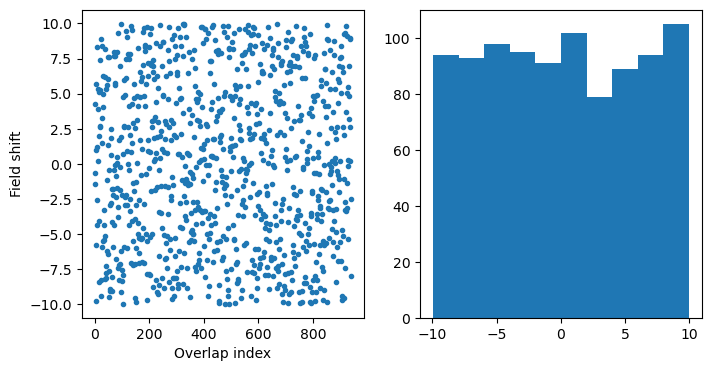

In [4]:
# 找到在place_index中，Overlap_index对应元素的索引
overlap_place_indices = np.zeros([map_num, Overlap_num])
overlap_place_fields = np.zeros([map_num, Overlap_num])
for i in range(map_num):
    indices = [np.where(place_index[i] == idx)[0][0] for idx in Overlap_index]
    overlap_place_indices[i] = indices
    overlap_place_fields[i] = maps[i][indices]


fig, ax = plt.subplots(1,2,figsize=(8,4))
# distance = Place_cell.period_bound(overlap_place_fields[0]-overlap_place_fields[1])
distance = Place_cell.period_bound(overlap_place_fields[0]-overlap_place_fields[1])
ax[0].plot(Overlap_index, distance,'.')
ax[0].set_xlabel('Overlap index')
ax[0].set_ylabel('Field shift')
ax[1].hist(distance)

## Embedding Multiple CANNs in one network
First, we check the connection matrix of the network.

/var/folders/cc/s0ls8jsx21n4zc1_dv62hvyc0000gn/T/ipykernel_41863/1197604532.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax[i].pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='viridis')


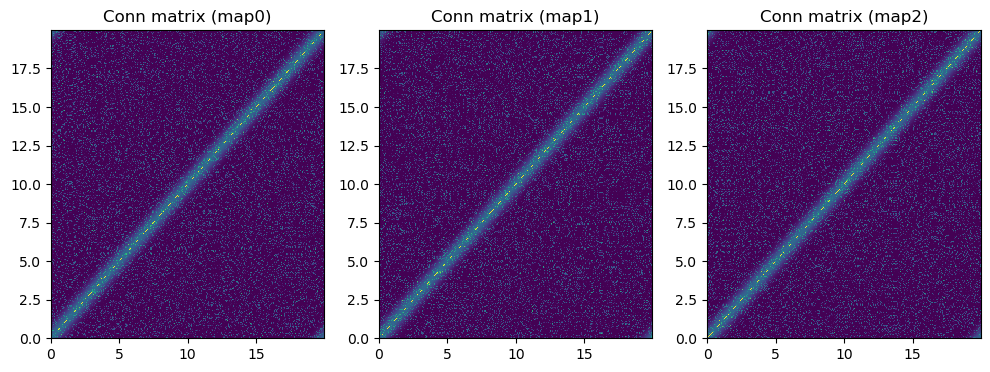

In [5]:
_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for i in range(map_num):
    # 获取排序后的索引
    sorted_indices = np.argsort(maps[i])
    sorted_maps = maps[i, sorted_indices]
    sorted_place_index = place_index[i, sorted_indices]
    sorted_conn_mat = conn_mat[np.ix_(sorted_place_index, sorted_place_index)]

    # 使用 pcolormesh 可视化矩阵
    ax[i].pcolormesh(sorted_maps, sorted_maps, sorted_conn_mat, cmap='viridis')
    # ax[i].colorbar()  # 添加颜色条
    ax[i].set_title('Conn matrix (map'+str(i)+')')


Next, we check the stationary states of a network embedding two maps in its connectivity.

In [6]:
map_index = 0
def run_net(indices, loc, input_stre):
    Place_cell.step_run(indices, loc=loc, map_index = map_index, input_stre=input_stre)
    u = Place_cell.u
    input = Place_cell.input
    return u, input

total_time = 10000
start_time = 1000
indices = bm.arange(total_time)
loc = bm.zeros(total_time) + (z_max+z_min)/2
print(loc)
input_stre = bm.zeros(total_time) 
input_stre[:start_time] = 10.
u, input = bm.for_loop(run_net, (indices, loc, input_stre), progress_bar = True)


Array(value=Array([10., 10., 10., ..., 10., 10., 10.]), dtype=float32)


  0%|          | 0/10000 [00:00<?, ?it/s]

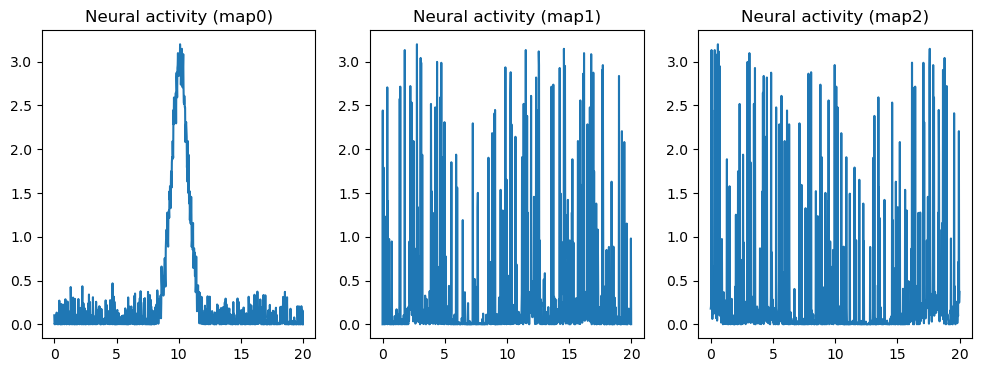

In [7]:
_, ax = plt.subplots(1,map_num,figsize=(map_num*4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(u[:, place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[:, sorted_indices]
    ax[map_index].plot(sorted_maps, sorted_u_place[-1,:])
    # ax[map_index].set_ylim([0, 5])
    ax[map_index].set_title('Neural activity (map'+str(map_index)+')')

0.70723015
0.10871465
0.13340013
[0.70723015 0.10871463 0.13340013]


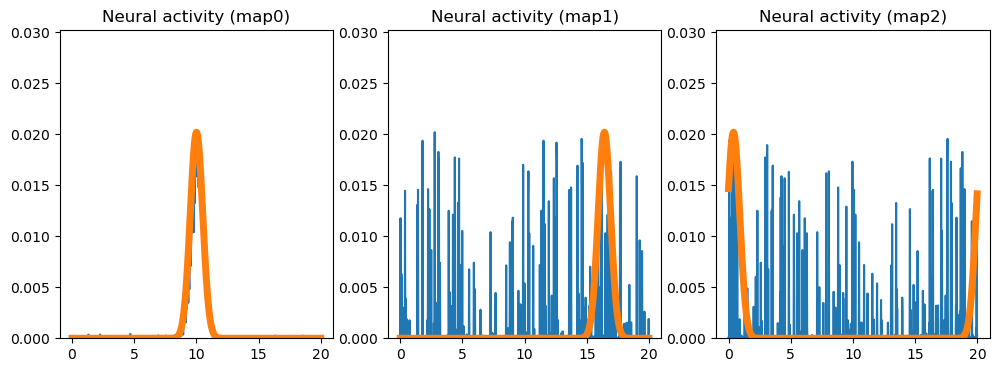

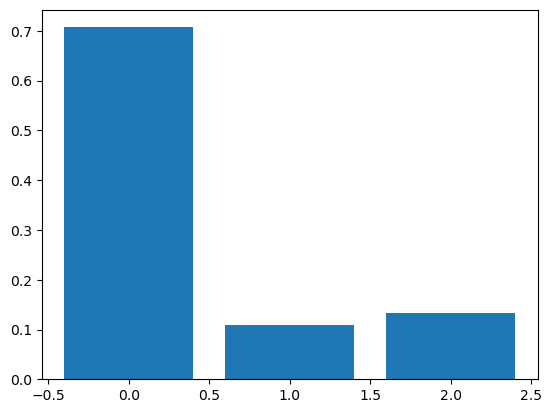

In [8]:
u = Place_cell.r
loc_num = 100
loc_candidate = np.linspace(z_min,z_max,loc_num,endpoint=False)
bump_score = np.zeros(map_num,)
max_score_pos = np.zeros(map_num,)
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    score_candidate = np.zeros(loc_num,)
    for j in range(loc_num):
        bump = Place_cell.get_bump(map_index, loc_candidate[j])
        u_place = u_place/bm.sum(u_place)
        score_candidate[j] = bm.sum(bump*u_place)
    bump_score[map_index] = np.max(score_candidate)
    max_score_pos[map_index] = loc_candidate[np.argmax(score_candidate)]

_, ax = plt.subplots(1, map_num, figsize=(map_num * 4, 4))
for map_index in range(map_num):
    u_place = bm.as_numpy(u[place_index[map_index]])
    sorted_indices = np.argsort(maps[map_index])
    sorted_maps = maps[map_index, sorted_indices]
    sorted_u_place = u_place[sorted_indices]
    bump = Place_cell.get_bump(map_index, max_score_pos[map_index])
    sorted_bump_normalize = bump[sorted_indices]
    bump_height = bm.max(sorted_u_place[:])
    sorted_bump = sorted_bump_normalize*bump_height

    print(bm.sum(sorted_u_place/bm.sum(sorted_u_place)*sorted_bump_normalize))
    ax[map_index].plot(sorted_maps, sorted_u_place)
    ax[map_index].plot(sorted_maps, sorted_bump, linewidth=5)
    ax[map_index].set_title('Neural activity (map' + str(map_index) + ')')
    ax[map_index].set_ylim(0, np.max(u[:])+0.01)
print(bump_score)
plt.savefig('figures/bump_activity.png')

plt.figure()
plt.bar(np.arange(map_num), bump_score)
plt.savefig('figures/bump_score.png')
